# Evaluation Notebook

### This notebook provides functions which can be used to compare the results of different models.
1) <b>get_all_labels</b> <br>
extracts all labels with its sole sequence number from a y list as preparation for future usage. <br>

2) It provides two methods to evaluation. <br>
2.1) The fist is shown by <b>get_classify_report</b>. <br>
The Classify Report reflects the accuracy of (simply) classification, not considering the rate of detecting.<br>
2.2) The second method shows the accuracy of recognition in strict sense. (<b>get_recognition_report</b>)<br>
Recognition Report shows how many entities are not only in accurate length detected but also correctly classified. <br>

3) <b>get_confusion_matrix</b> <br>
returns confusion_matrix in three categories: juridical_person, formats, natural_person

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import sparse
import re

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

## Load the feature matrix (sparse) and the model

In [3]:
sparse_train = sp.sparse.load_npz('transitional_data/X5_train.npz')
sparse_dev = sp.sparse.load_npz('transitional_data/X5_dev.npz')

In [19]:
y_train = pd.read_csv("transitional_data/y_train.csv")
y_dev = pd.read_csv("transitional_data/y_dev.csv")

In [5]:
y_train = y_train.groupby(by = 'SentenceNR', group_keys=True).apply(lambda x: x)
y_train = y_train.rename(columns={"SentenceNR": "Sent", "Unnamed: 1": "TokenNr"})

In [6]:
y_dev = y_dev.groupby(by = 'SentenceNR', group_keys=True).apply(lambda x: x)
y_dev = y_dev.rename(columns={"SentenceNR": "Sent", "Unnamed: 1": "TokenNr"})

In [7]:
train_true = y_train["Label"]
dev_true = y_dev["Label"]

In [8]:
classes = ['B-ORG', 'I-ORG', 'B-OTHER_PERSON', 'I-OTHER_PERSON', 'B-WITNESS', 'I-WITNESS', 'B-GPE', 'B-STATUTE', 'B-DATE', 'I-DATE', 'B-PROVISION', 'I-PROVISION', 'I-STATUTE', 'B-COURT', 'I-COURT', 'B-PRECEDENT', 'I-PRECEDENT', 'B-CASE_NUMBER', 'I-CASE_NUMBER', 'I-GPE', 'B-PETITIONER', 'I-PETITIONER', 'B-JUDGE', 'I-JUDGE', 'B-RESPONDENT', 'I-RESPONDENT']

In [9]:
svc = LinearSVC()
%time svc.fit(sparse_train, train_true)

CPU times: user 1min 4s, sys: 439 ms, total: 1min 4s
Wall time: 1min 5s


LinearSVC()

In [10]:
%%time
dev_pred = svc.predict(sparse_dev)
# print(classification_report(y_pred = dev_pred, y_true = dev_true, labels = classes))

CPU times: user 39.2 ms, sys: 3.21 ms, total: 42.4 ms
Wall time: 41.5 ms


## get_all_labels
This function extracts <b>all labels with its sole sequence number</b> from a y list. <br>
It returns a nested list: Each element of the list (a named entity) is itself a list of labels. Each label is also a list of two elements, the first is the sequence number, the second the true/predicted label. e. g.<br>
<blockquote>[ [38, 'B-PRECEDENT'],<br> 
    [39, 'I-PRECEDENT'],<br> 
    [40, 'I-PRECEDENT'],<br> 
    [41, 'I-PRECEDENT'],<br> 
    [42, 'I-PRECEDENT'],<br> 
    [43, 'I-PRECEDENT'] ],<br> </blockquote>
A named entity including 6 labels(tokens). 

In [11]:
def get_all_labels(label_list):
    labels = []
    for i in range (len(label_list)):
        label = []
        if label_list[i].startswith("B"):
            label.append([i, label_list[i]])
            
            c = i + 1
            while True:
                if label_list[c].startswith("I"):
                    label.append([c, label_list[c]])
                else:
                    break
                c += 1
                
            labels.append(label)
            label = []
    return labels

In [12]:
%time labels_pred = get_all_labels(dev_pred)
%time labels_true = get_all_labels(dev_true.tolist())

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 12.1 ms
CPU times: user 8.26 ms, sys: 8 µs, total: 8.27 ms
Wall time: 8.27 ms


## get_classify_report
### Classify Report reflects the accuracy of (simply) classification, not considering the rate of detecting.
This functions returns two lists of <b>LABEL of Entities</b> with the same length, if no error appears. <br>
They show the "common" entities in true list and pred list. <br>
In specific, these entities must have the <b>SAME SPAN</b>, (covering the same tokens, not langer, not shorter) <br>
But they <b>don't</b> necessarily have same <b>LABELs</b>. <br><br>
So they are called <i>detected_true</i>, (entities in the true list which are found by the prediction)<br>
and <i>valid_pred</i>. (entities in the pred list, whose span are correct according to the true list)<br>
They both will be returned after running the function.<br><br>
The parameter <i>report</i> requires a boolean value. If True, it will print a classification_report,<br>
which reflects the <b>accuracy of (simply) classification</b> of the model, which means,<br>
<i>if the entities are in accurate spans detected, how many of them can be classified into the correct class. </i><br>
I will call it as <b>classify_report</b> in the future, to distinguish it with the strict <b>recognition_report</b> later.

In [13]:
def get_classify_report(true, pred, report=False):
    
    detected_true = []
    valid_pred = []

    for l in range(len(pred)):
        for t in range(len(true)):
            # Check whether they cover the exact same span or not:
            if [label[0] for label in pred[l]] == [label[0] for label in true[t]]:
                # The labels will be combined. 
                # detected_true and valid_pred are list of the names of entities [CASE_NUMBER, COURT ...]
                detected_true.append(true[t][0][1][2:])
                valid_pred.append(pred[l][0][1][2:])
                
    if len(detected_true) == len(valid_pred):
        if report == True:
            classes = sorted(list(set(valid_pred + detected_true)))
            print(classification_report(y_pred = valid_pred, y_true = detected_true, labels = classes))
        return detected_true, valid_pred
    else:
        raise ValueError

In [14]:
detected_true, valid_pred = get_classify_report(labels_true, labels_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.99      0.94      0.96        71
       COURT       0.99      0.99      0.99       135
        DATE       1.00      1.00      1.00       208
         GPE       0.97      0.87      0.92       118
       JUDGE       0.55      0.86      0.67         7
         ORG       0.75      0.85      0.79        59
OTHER_PERSON       0.85      0.78      0.82       204
  PETITIONER       0.11      0.33      0.17         6
   PRECEDENT       0.74      0.79      0.76        53
   PROVISION       1.00      1.00      1.00       198
  RESPONDENT       0.20      0.50      0.29         2
     STATUTE       0.98      0.99      0.98       164
     WITNESS       0.64      0.64      0.64        42

    accuracy                           0.91      1267
   macro avg       0.75      0.81      0.77      1267
weighted avg       0.93      0.91      0.92      1267



## get_recognition_report
### Recognition Report shows how many entities are not only in accurate span detected but also correctly classified. <br>
It returns a dataframe <i>all_labels_compare</i> sorted with the unique span of entities (both in true und in pred) as index<br>
and their labels (combined) in true and predict.<br>
If an entity span doesn't appear in the true/ pred list, it will be fillded with "o".

In [16]:
def get_recognition_report(true, pred, report=False):
    
    # create a dictionary to save the union of all entites in pred and in true. 
    # keys are the spans of each entites, values are dictionaries inside, 
    # which save the labels of these entities in the true list and pred list. 
    all_label_spans = {}
    
    for i in range(len(pred)):
        label = pred[i]
        label_span = [token[0] for token in label]
        all_label_spans[str(label_span)] = {"pred": pred[i][0][1][2:]}
        all_label_spans[str(label_span)]["true"] = "o"

    for i in range(len(true)):
        label = true[i]
        label_span = [token[0] for token in label]
        if str(label_span) in all_label_spans:
            all_label_spans[str(label_span)]["true"] = true[i][0][1][2:]
        else:
            all_label_spans[str(label_span)] = {"true": true[i][0][1][2:]}
            all_label_spans[str(label_span)]["pred"] = "o"
    
    all_labels_compare = pd.DataFrame.from_dict(all_label_spans).transpose()
    
    if report == True:
        classes = sorted(list(set(all_labels_compare["true"])))
        classes.remove("o")
        print(classification_report(y_pred = all_labels_compare["pred"], y_true = all_labels_compare["true"], labels = classes))
        
    return all_labels_compare

In [17]:
all_labels_compare = get_recognition_report(true = labels_true, pred = labels_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.56      0.55      0.56       121
       COURT       0.82      0.75      0.79       178
        DATE       0.92      0.94      0.93       222
         GPE       0.63      0.57      0.60       182
       JUDGE       0.29      0.75      0.41         8
         ORG       0.41      0.31      0.36       159
OTHER_PERSON       0.68      0.58      0.62       276
  PETITIONER       0.09      0.22      0.13         9
   PRECEDENT       0.29      0.24      0.26       177
   PROVISION       0.78      0.77      0.77       258
  RESPONDENT       0.06      0.20      0.09         5
     STATUTE       0.75      0.73      0.74       222
     WITNESS       0.45      0.47      0.46        58

   micro avg       0.66      0.62      0.64      1875
   macro avg       0.52      0.54      0.52      1875
weighted avg       0.66      0.62      0.64      1875



## get_confusion_matrix
### Returns confusion_matrix in three categories: juridical_person, formats, natural_person
The first two parameters pred and true are labels of entities, they must have the same length. <br>
The three categories of labels can be chosen with "cat".

In [134]:
def get_confusion_matrix(pred, true, cat="natural_person"):
    
    juridical_person = ["COURT", "GPE", "ORG"]
    formats = ["CASE_NUMBER", "PRECEDENT", "PROVISION", "STATUTE", "DATE"]
    natural_person = ["JUDGE", "OTHER_PERSON", "PETITIONER", "RESPONDENT", "WITNESS"]
    labels = []
    display_labels = []
    
    if len(pred) == len(true):
        
        if cat == "natural_person":
            labels += natural_person
            display_labels += ["JUDGE", "OTHER", "PETITIONER", "RESPONDENT", "WITNESS"]
        elif cat == "juridical_person":
            labels += juridical_person
            display_labels += labels
        elif cat == "formats":
            labels += formats
            display_labels += ["CASE", "PRECEDENT", "PROVISION", "STATUTE", "DATE"]
        else:
            labels = natural_person + juridical_person + formats
            display_labels += labels
        
        cm = confusion_matrix(y_pred = pred, y_true = true, labels = labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = display_labels)
        disp.plot()
        
    else:
        raise ValueError

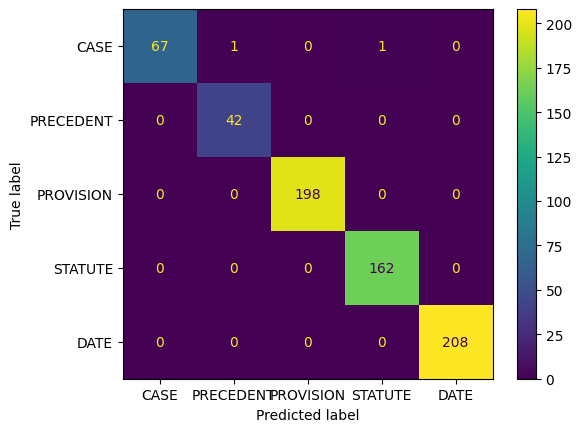

In [141]:
get_confusion_matrix(pred = all_labels_compare["pred"], true = all_labels_compare["true"], cat="formats")

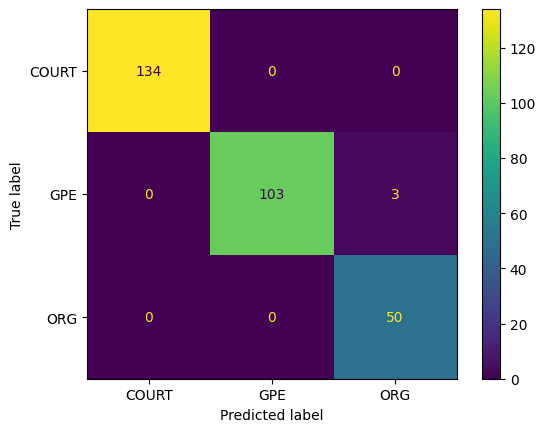

In [142]:
get_confusion_matrix(pred = all_labels_compare["pred"], true = all_labels_compare["true"], cat="juridical_person")

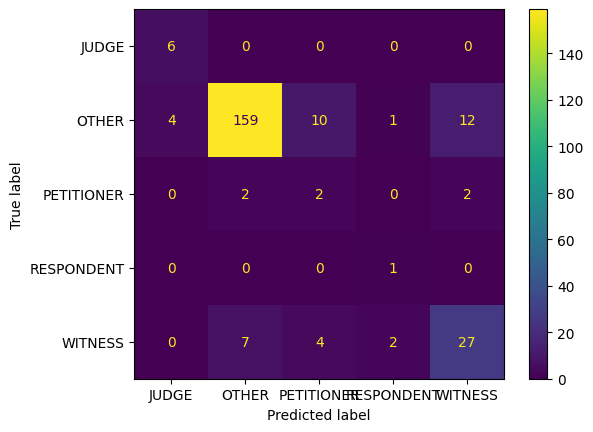

In [143]:
get_confusion_matrix(pred = all_labels_compare["pred"], true = all_labels_compare["true"], cat="natural_person")